## Goals: Feature Engineering

This notebook merge *Brazil* and *France* dataset into a single training dataset.
It adds seasonal information (seasons, month), scale relevent features and removed unecessary columns.

> Note this notebook need ouputs from both *01a - Data Preprocessing Brazil* and 01b - *Data Preprocessing France*

![Alt text](../images/notebook-2.png)

### 1. Data Import and Setup

Imports necessary libraries, sets up environment paths, and includes custom utility functions.



In [19]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.append(BASE_DIR)

from src.utils.plots import plot_water_flows

Defines constants :
* INPUT_DIR must be the same as the one defined in *01 - Data Preprocessing* notebook.
* EVAL_DIR must be the same as the one defined in *01 - Data Preprocessing* notebook.

In [20]:
INPUT_DIR = "../../../data/input/"
EVAL_DIR = "../../../data/evaluation/"

DATASET_SPEC = "pca_and_sin_season_encode"

datasets = { "train": INPUT_DIR, "eval" : EVAL_DIR}


### 2. Data Loading and Initial Cleaning

* Reads in the French and Brazilian baseline datasets, removes unnecessary columns, and sets the date as the index.
* Introduces a binary indicator (`north_hemisphere`) to distinguish between data from France and Brazil.
* Merges the French and Brazilian datasets into a single DataFrame for further processing.

In [21]:
dataset_baseline = {}

for set, dir in datasets.items():
    path_data_baseline_france = f"{dir}preprocessed_france.csv"
    dataset_baseline_france = pd.read_csv(path_data_baseline_france)

    dataset_baseline_france = dataset_baseline_france.iloc[:,1:]
    dataset_baseline_france = dataset_baseline_france.drop(columns=["index"])


    dataset_baseline_france = (
        dataset_baseline_france
        .set_index("ObsDate")
    )

    path_data_baseline = f"{dir}preprocessed_brazil.csv"
    dataset_baseline_brazil = pd.read_csv(path_data_baseline)

    # remove the first column
    dataset_baseline_brazil = dataset_baseline_brazil.iloc[:,1:]
    dataset_baseline_brazil = dataset_baseline_brazil.drop(columns=["index"])

    dataset_baseline_brazil = (
        dataset_baseline_brazil
        .set_index("ObsDate")
    )


    dataset_baseline_france["north_hemisphere"] = 1
    dataset_baseline_brazil["north_hemisphere"] = 0

    dataset_baseline[set] = pd.concat([dataset_baseline_france, dataset_baseline_brazil], axis=0)

### 3. Feature Engineering

Creates seasonal and monthly indicator columns.


In [22]:
for set, dir in datasets.items():
    # Convert the index to datetime and extract the month
    month = pd.to_datetime(dataset_baseline[set].index).month

    # Define season mappings
    seasons = {
        "is_winter": [1, 2, 3],
        "is_spring": [4, 5, 6],
        "is_summer": [7, 8, 9],
        "is_autumn": [10, 11, 12],
    }

    # Apply season flags
    for season, months in seasons.items():
        dataset_baseline[set][season] = month.isin(months)

    # Define month abbreviations and apply monthly flags
    months_abbr = ["jan", "feb", "mar", "apr", "may", "jun",
                "jul", "aug", "sep", "oct", "nov", "dec"]
    for i, abbr in enumerate(months_abbr, start=1):
        dataset_baseline[set][f"is_{abbr}"] = month == i

Applies MinMax scaling to the selected features.

In [23]:
for set, dir in datasets.items():
    scaler = MinMaxScaler()
    cols = dataset_baseline[set].columns
    # remove the water_flows columns
    if set == "eval":
        cols = cols.drop(["station_code", "water_flow_lag_1w", "water_flow_lag_2w"])
    elif set == "train":
        cols = cols.drop(["water_flow_week1", "station_code", "water_flow_week2", "water_flow_week3", "water_flow_week4", "water_flow_lag_1w"])
    dataset_baseline[set][cols] = scaler.fit_transform(dataset_baseline[set][cols])

### 4. Handling Missing Data

Removes undesired columns, identifies columns with missing values, and imputes them with their respective column means.


In [24]:
# remove columns that start with index_
for set, dir in datasets.items():
    cols = dataset_baseline[set].columns
    cols = cols[~cols.str.startswith("index_")]
    dataset_baseline[set] = dataset_baseline[set][cols]

    # find columns that contains nan values

    cols_nan = dataset_baseline[set].columns[dataset_baseline[set].isna().any()].tolist()

    # impute nan values with the mean
    for col in cols_nan:
        dataset_baseline[set][col] = dataset_baseline[set][col].fillna(dataset_baseline[set][col].mean())

### **4.1 Data aggregation on temporal data through scope**

In [25]:
# Usefull for pca analysis

def cumulative_sum(arr):
    result = []
    current_sum = 0
    for num in arr:
        current_sum += num
        result.append(current_sum)
    return result

def plot_cumulative_variance(cumulative_sums1, cumulative_sums2, 
                             title1="Cumulative sum of explained variance train set", 
                             title2="Cumulative sum of explained variance eval set"):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(cumulative_sums1, marker='o')
    plt.title(title1)
    plt.xlabel('Index')
    plt.ylabel('Variance')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(cumulative_sums2, marker='o', color='orange')
    plt.title(title2)
    plt.xlabel('Index')
    plt.ylabel('Variance')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def find_index_exceeding_threshold(values, threshold=0.98):
    for i, val in enumerate(values):
        if val >= threshold:
            return i
    return -1

### 4.1.1 Executing PCA strategy on specific features

Original train dataset shape (28431, 159)
Original eval dataset shape (1352, 155)
**** Processing

Processing pca dimension reduction on soil_composition, 96 features
Processing train dataset ...
Processing eval dataset ...
Kept pcs : Index(['soil_composition_pca_1', 'soil_composition_pca_2',
       'soil_composition_pca_3', 'soil_composition_pca_4',
       'soil_composition_pca_5', 'soil_composition_pca_6',
       'soil_composition_pca_7', 'soil_composition_pca_8',
       'soil_composition_pca_9', 'soil_composition_pca_10'],
      dtype='object')
Only 10 pcs kept, compared to initial 96 values


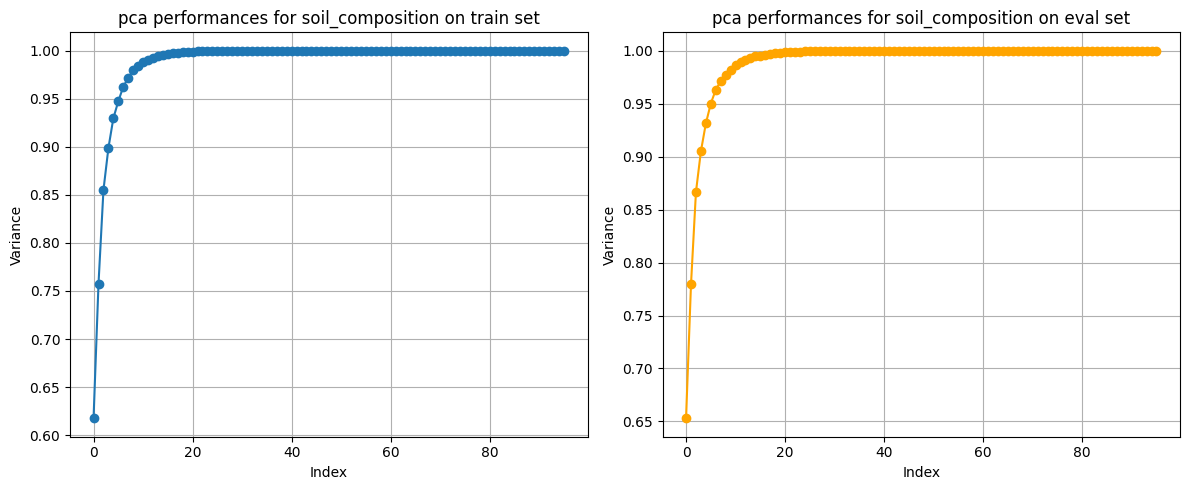

Processing pca dimension reduction on evaporation, 5 features
Processing train dataset ...
Processing eval dataset ...
Kept pcs : Index(['evaporation_pca_1'], dtype='object')
Only 1 pcs kept, compared to initial 5 values


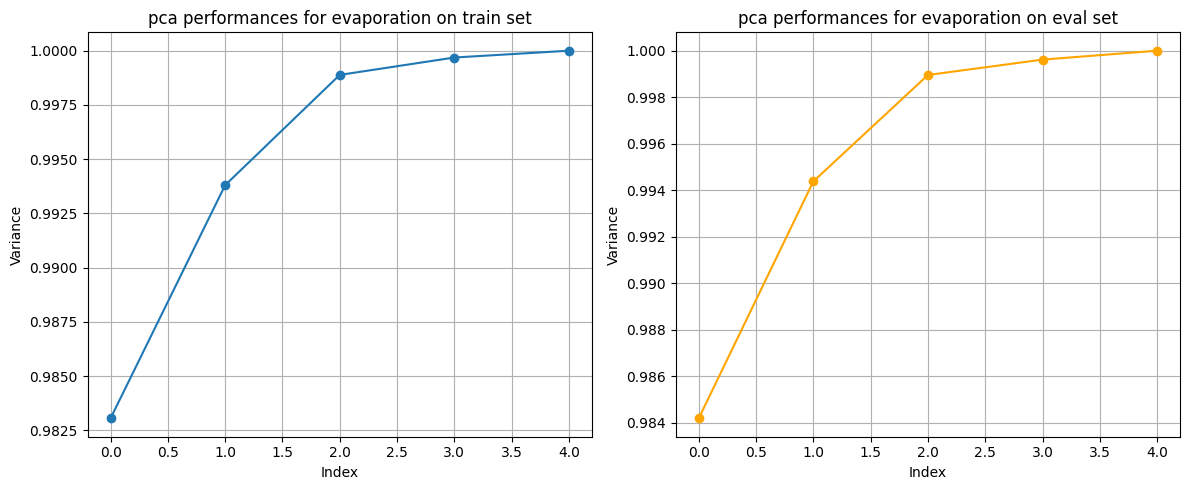

Processing pca dimension reduction on evaporation_lag_1w, 5 features
Processing train dataset ...
Processing eval dataset ...
Kept pcs : Index(['evaporation_lag_1w_pca_1'], dtype='object')
Only 1 pcs kept, compared to initial 5 values


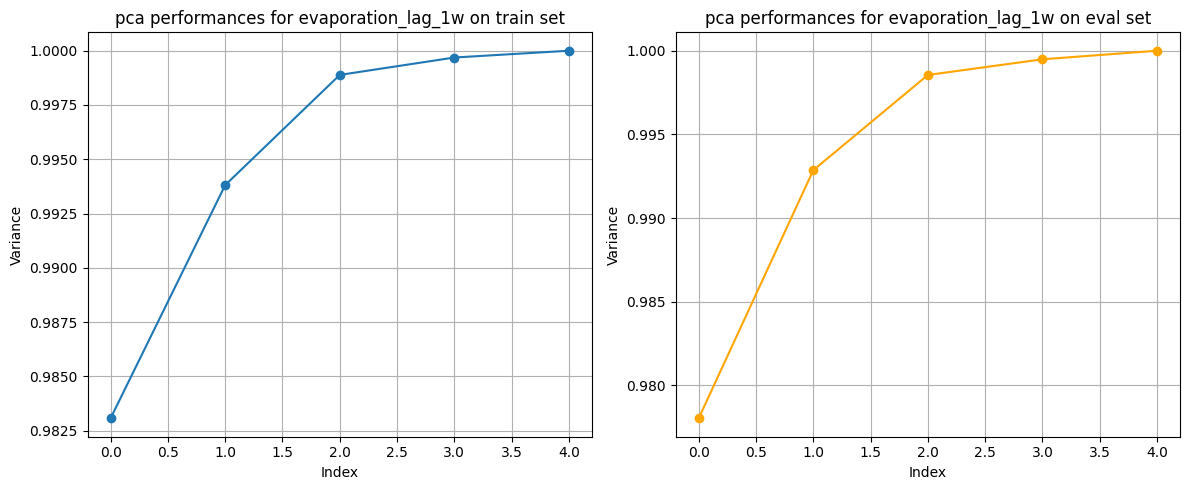

Processing pca dimension reduction on soil_moisture, 5 features
Processing train dataset ...
Processing eval dataset ...
Kept pcs : Index(['soil_moisture_pca_1', 'soil_moisture_pca_2'], dtype='object')
Only 2 pcs kept, compared to initial 5 values


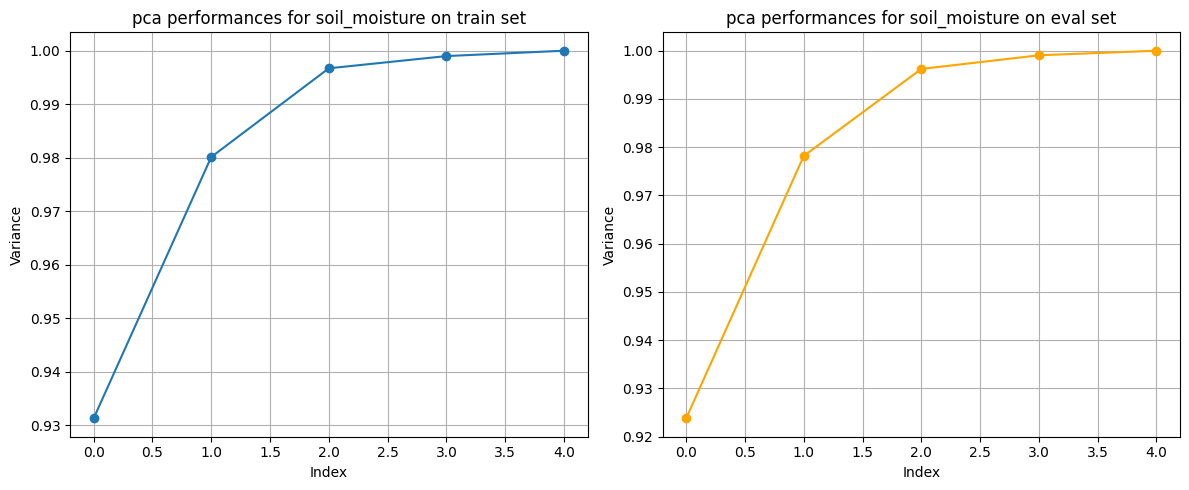

Processing pca dimension reduction on tempartures, 5 features
Processing train dataset ...
Processing eval dataset ...
Kept pcs : Index(['tempartures_pca_1'], dtype='object')
Only 1 pcs kept, compared to initial 5 values


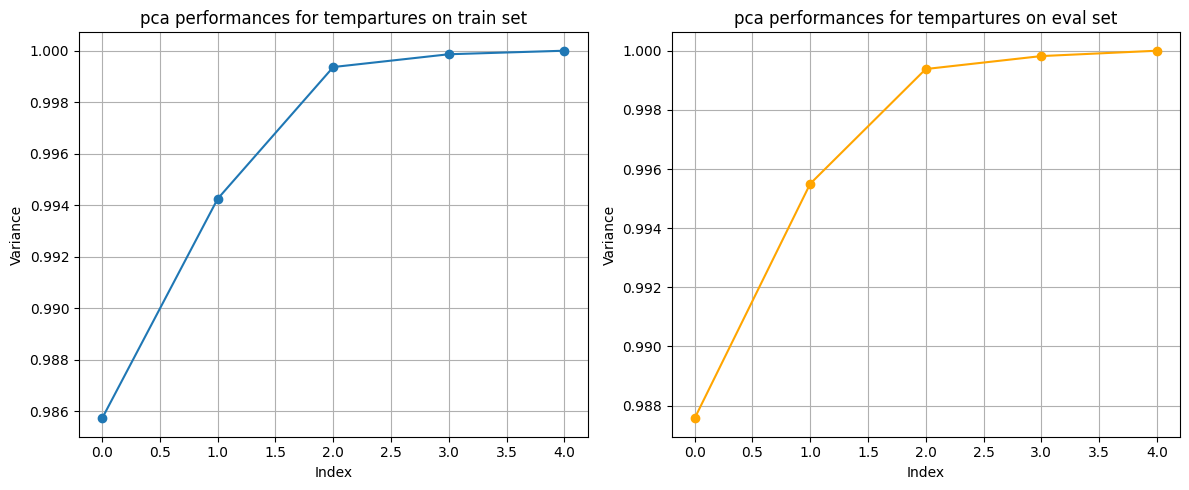

Processing pca dimension reduction on tempartures_lag_1w, 5 features
Processing train dataset ...
Processing eval dataset ...
Kept pcs : Index(['tempartures_lag_1w_pca_1'], dtype='object')
Only 1 pcs kept, compared to initial 5 values


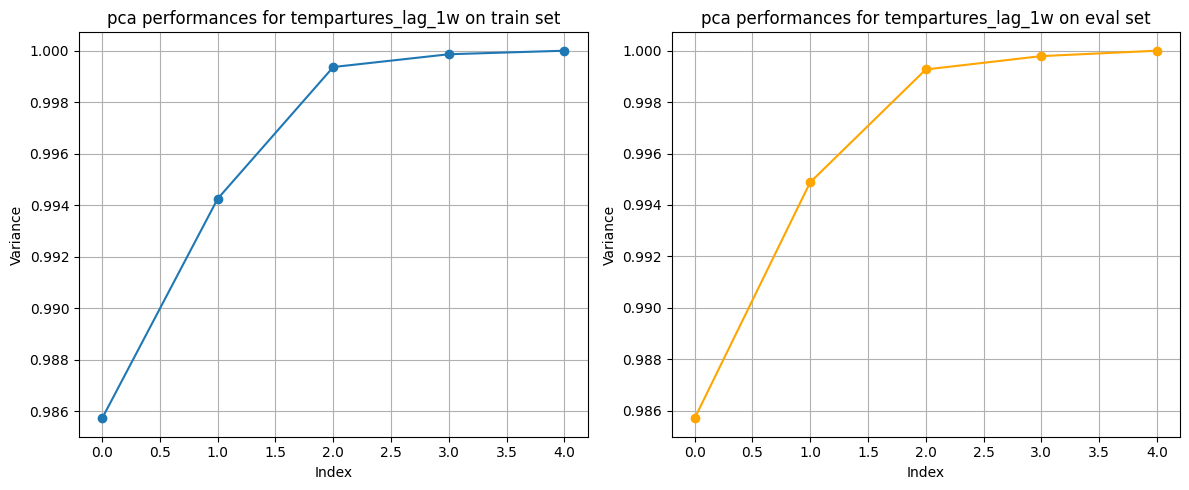

Processing pca dimension reduction on precipitations, 5 features
Processing train dataset ...
Processing eval dataset ...
Kept pcs : Index(['precipitations_pca_1', 'precipitations_pca_2'], dtype='object')
Only 2 pcs kept, compared to initial 5 values


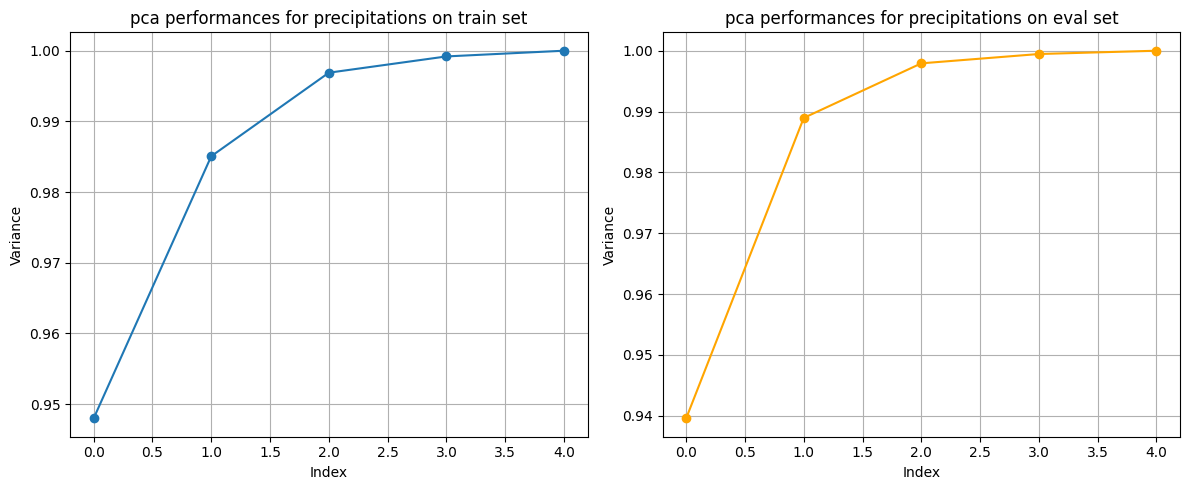

Processing pca dimension reduction on precipitations_lag_1w, 5 features
Processing train dataset ...
Processing eval dataset ...
Kept pcs : Index(['precipitations_lag_1w_pca_1', 'precipitations_lag_1w_pca_2'], dtype='object')
Only 2 pcs kept, compared to initial 5 values


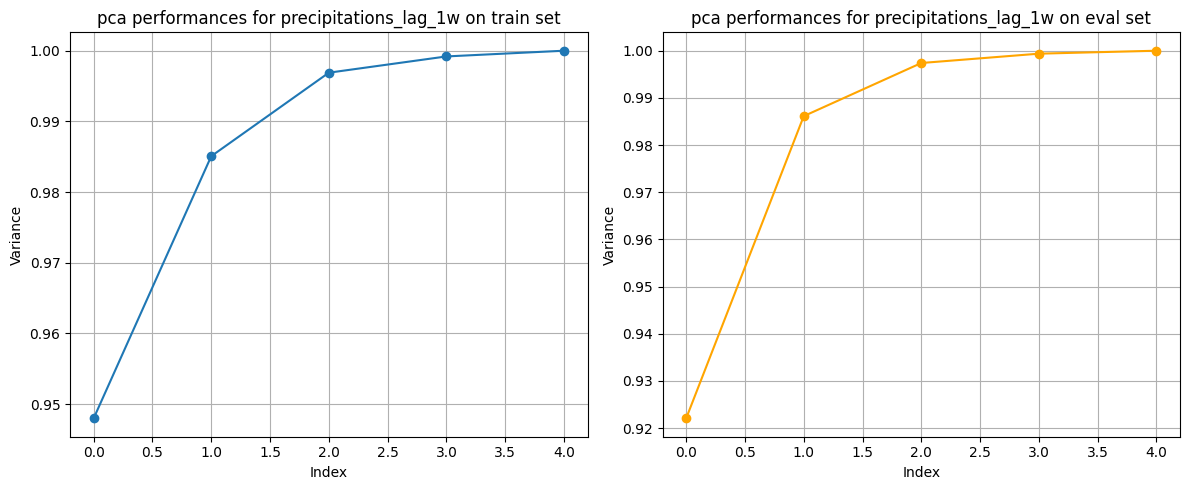

**** END Processing
Final train dataset shape (28431, 48)
Final eval dataset shape (1352, 44)
30.19% of initial features


In [26]:
aggregation_lists = {
    "soil_composition": 
        [
        f"{var}_{depth}_mean_index__{scope}"
        for var in ["sand", "bdod", "cfvo", "clay"]
        for depth in ["0-5cm", "5-15cm", "15-30cm", "30-60cm", "60-100cm", "100-200cm"]
        for scope in ["region", "zone", "sector", "sub_sector"]
        ],
    "evaporation": 
        [
        f"evaporation{scope}"
        for scope in ["", "_region", "_zone", "_sector", "_sub_sector"]
        ],
    "evaporation_lag_1w": 
        [
        f"evaporation{scope}_lag_1w"
        for scope in ["", "_region", "_zone", "_sector", "_sub_sector"]
        ],
    "soil_moisture" : 
        [
            f"soil_moisture{scope}"
            for scope in ["", "_region", "_zone", "_sector", "_sub_sector"]
        ],
    "tempartures":
        [
            f"temperature{scope}"
            for scope in ["s", "_region", "_zone", "_sector", "_sub_sector"]
        ],
    "tempartures_lag_1w":
        [
            f"temperature{scope}_lag_1w"
            for scope in ["s", "_region", "_zone", "_sector", "_sub_sector"]
        ],
    "precipitations":
        [
            f"precipitation{scope}"
            for scope in ["s", "_region", "_zone", "_sector", "_sub_sector"]
        ],
    "precipitations_lag_1w":
        [
            f"precipitation{scope}_lag_1w"
            for scope in ["s", "_region", "_zone", "_sector", "_sub_sector"]
        ],
}

initial_features_train = dataset_baseline["train"].shape[1]

print(f"Original train dataset shape {dataset_baseline['train'].shape}")
print(f"Original eval dataset shape {dataset_baseline['eval'].shape}")
print("**** Processing")
print("")

for list_name, key_list in aggregation_lists.items():
    print(f"Processing pca dimension reduction on {list_name}, {len(key_list)} features")
    
    # This enable having the same pcs numbers on eval and train set
    nbPcsToKeep = -1
    cumulative_sums = {}
    generated_columns = []

    for set, dir in datasets.items():
        print(f"Processing {set} dataset ...")

        original_index = dataset_baseline[set][key_list].index 

        pca = PCA(n_components=len(key_list))
        pca_data = pca.fit_transform(dataset_baseline[set][key_list])

        # Plot the cumulative variance of the PCA
        cumulative_sums[set] = cumulative_sum(pca.explained_variance_ratio_)

        if nbPcsToKeep == -1:
            nbPcsToKeep = find_index_exceeding_threshold(cumulative_sums[set], 0.98)

        pca_df = pd.DataFrame(pca_data, index=original_index)

        pca_df.columns = [f"{list_name}_pca_{i+1}" for i in range(pca_df.shape[1])]
        pca_df = pca_df.iloc[:, :nbPcsToKeep + 1]
        
        generated_columns = pca_df.keys()

        dataset_baseline[set] = pd.concat([dataset_baseline[set], pca_df], axis=1)
        dataset_baseline[set] = dataset_baseline[set].drop(columns=key_list)
    
    print(f"Kept pcs : {generated_columns}")
    print(f"Only {nbPcsToKeep + 1} pcs kept, compared to initial {len(key_list)} values")
    plot_cumulative_variance(cumulative_sums["train"], cumulative_sums["eval"],  f"pca performances for {list_name} on train set",f"pca performances for {list_name} on eval set")

print("**** END Processing")
    

print(f"Final train dataset shape {dataset_baseline['train'].shape}")
print(f"Final eval dataset shape {dataset_baseline['eval'].shape}")

print(f"{dataset_baseline['train'].shape[1] / initial_features_train * 100:.2f}% of initial features")

#### 4.2 Sine and Cosine month encoding

In [27]:
def convert_one_hot_to_label(df, columns, column_name):
    df[column_name] = np.argmax(df[columns].values, axis=1) + 1
    df = df.drop(columns=columns)
    return df


def encode_cyclical(df, column, max_val, drop_original=True):
    df[f"{column}_sin"] = np.sin(df[column] * (2 * np.pi / max_val))
    df[f"{column}_cos"] = np.cos(df[column] * (2 * np.pi / max_val))

    if drop_original:
        df = df.drop(columns=[column])
    return df

##### 4.3.1 Converting on-hot to index encoding


In [28]:
# List of month column names
month_cols = [
    "is_jan",
    "is_feb",
    "is_mar",
    "is_apr",
    "is_may",
    "is_jun",
    "is_jul",
    "is_aug",
    "is_sep",
    "is_oct",
    "is_nov",
    "is_dec",
]

dataset_baseline["train"] = convert_one_hot_to_label(
    dataset_baseline["train"], month_cols, "month"
)
dataset_baseline["eval"] = convert_one_hot_to_label(
    dataset_baseline["eval"], month_cols, "month"
)

In [29]:
seasons_cols = ["is_winter", "is_spring", "is_summer", "is_autumn"]

dataset_baseline["train"] = convert_one_hot_to_label(
    dataset_baseline["train"], seasons_cols, "season"
)
dataset_baseline["eval"] = convert_one_hot_to_label(
    dataset_baseline["eval"], seasons_cols, "season"
)

##### 4.3.2 Converting index encoding to Cyclical encoding


In [30]:
dataset_baseline["train"] = encode_cyclical(dataset_baseline["train"], "month", 12)
dataset_baseline["eval"] = encode_cyclical(dataset_baseline["eval"], "month", 12)

In [31]:
dataset_baseline["train"] = encode_cyclical(dataset_baseline["train"], "season", 4)
dataset_baseline["eval"] = encode_cyclical(dataset_baseline["eval"], "season", 4)

### 5. Data Saving, and Visualization

Saves the complete baseline.

In [32]:
for set, dir in datasets.items():
    dataset_baseline[set].to_csv(f"{dir}dataset_{DATASET_SPEC}.csv")

Visualizes the water flow for the 10 first stations.

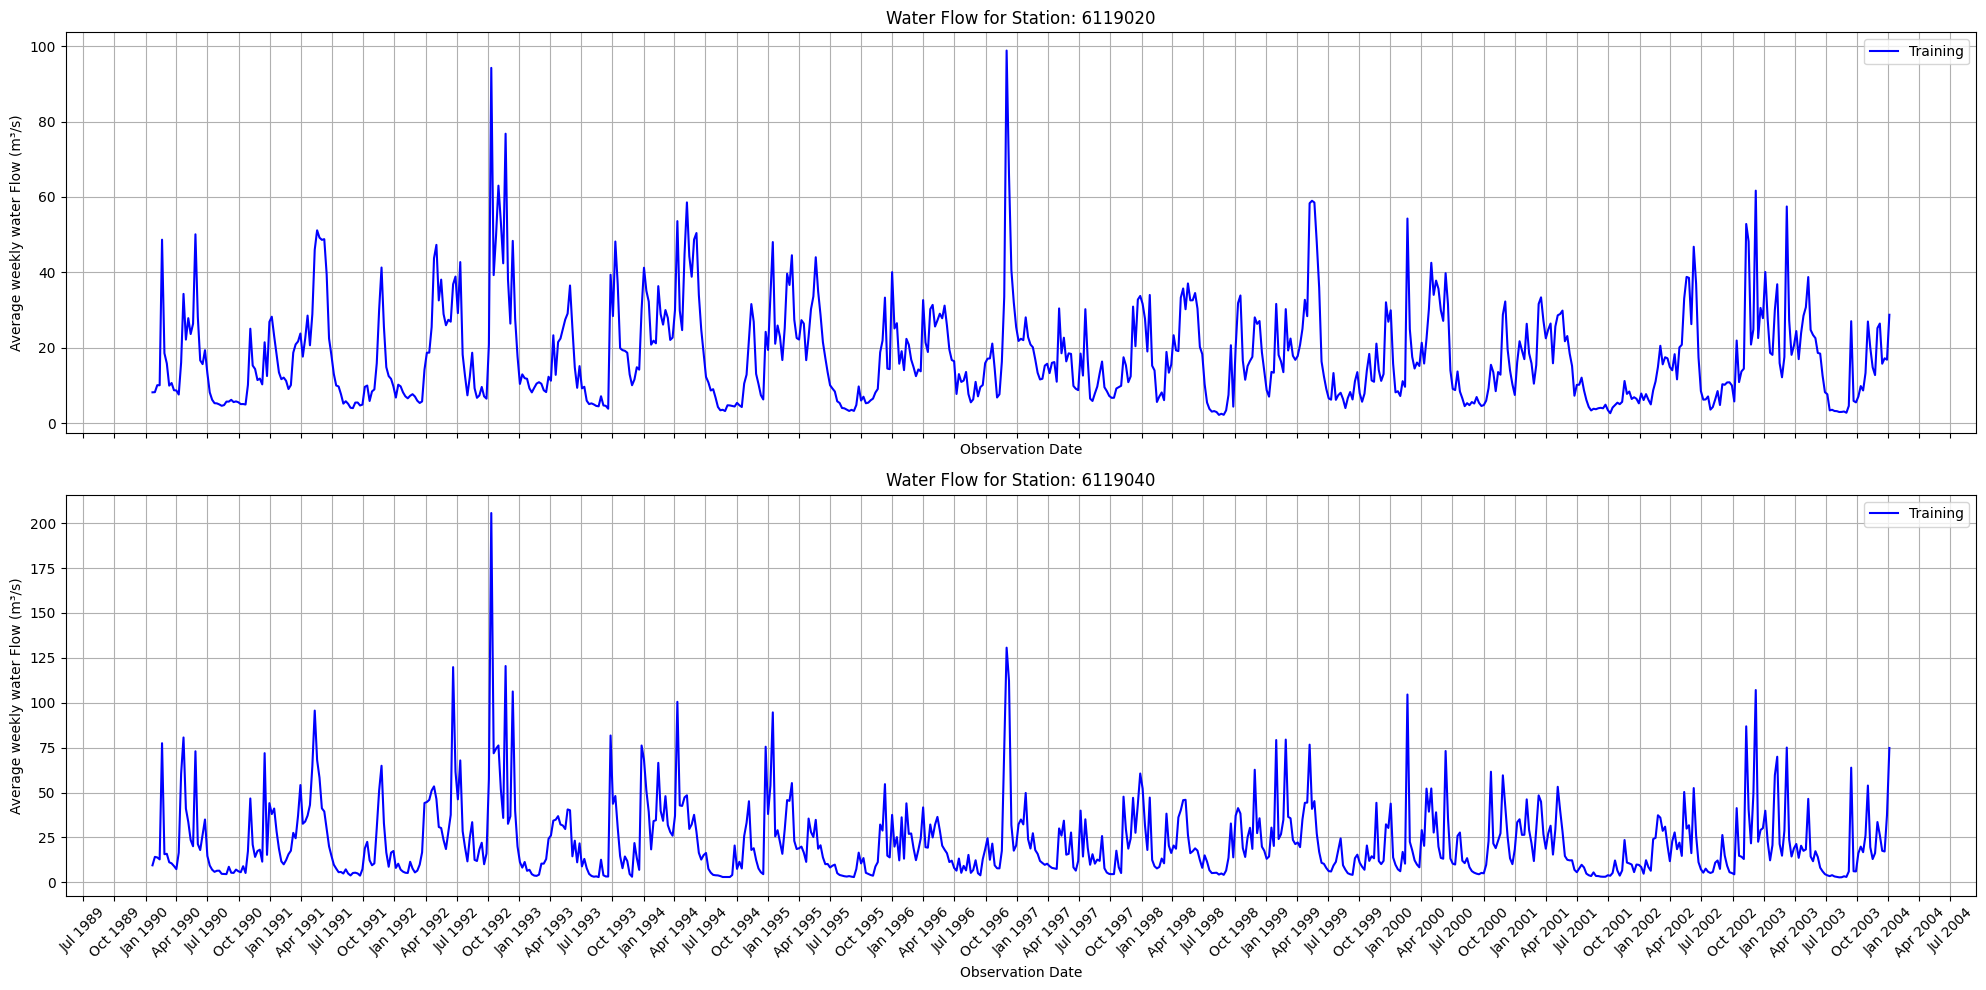

In [33]:
plot_water_flows(dataset_baseline["train"], max_stations = 2, display = True, save = False)